In [1]:
#%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#  The schema and table can be viewed at https://sqliteonline.com/
#  Or by installing DB Browser for SQLite
dict(Measurement.__table__.columns)

{'id': Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 'station': Column('station', TEXT(), table=<measurement>),
 'date': Column('date', TEXT(), table=<measurement>),
 'prcp': Column('prcp', FLOAT(), table=<measurement>),
 'tobs': Column('tobs', FLOAT(), table=<measurement>)}

In [11]:
dict(Station.__table__.columns)

{'id': Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 'station': Column('station', TEXT(), table=<station>),
 'name': Column('name', TEXT(), table=<station>),
 'latitude': Column('latitude', FLOAT(), table=<station>),
 'longitude': Column('longitude', FLOAT(), table=<station>),
 'elevation': Column('elevation', FLOAT(), table=<station>)}

In [12]:
# Display the row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x17347541828>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [13]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x17347551358>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

# Exploratory Climate Analysis

In [14]:
from datetime import timedelta as td
from sqlalchemy import and_
import matplotlib.dates as mdates

<class 'str'> 2016-08-23


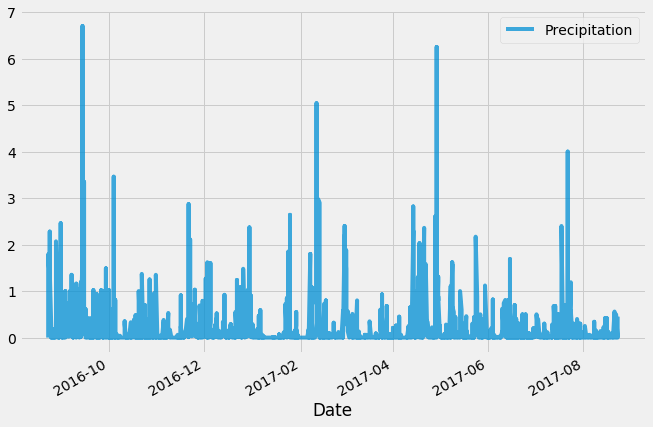

In [15]:
from matplotlib import style
style.use('fivethirtyeight')

# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_entry = session.query(Measurement).order_by(Measurement.date.desc())

# Calculate the date 1 year ago from today
last_entry_year = last_entry.first().__dict__['date']
prev_year = (dt.datetime.strptime(last_entry_year, "%Y-%m-%d") -td(365)).strftime("%Y-%m-%d")
print(type(prev_year), prev_year)

# Perform a query to retrieve the data and precipitation scores
prec_data = session.query(Measurement.date, Measurement.prcp).filter(
    and_(Measurement.date >= prev_year, Measurement.prcp != None))
x_val, y_val = zip(*prec_data)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame({"Date" : x_val,
                   "Precipitation" : y_val})
df['Date'] = pd.to_datetime(df['Date'])
#df.index = pd.to_datetime(df.index)
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(alpha=0.75, figsize=(10,7))

# Rotate the xticks for the dates
plt.savefig('figs/precp_results.png', bbox_inches='tight')
plt.show()


In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

# Rotate the xticks for the dates


In [17]:
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data


In [19]:
# How many stations are available in this dataset?


In [20]:
total_stations = session.query(Station).count()
st = session.query(Station)
print(f"Total stations = {total_stations}")
print("Station names:")
for s in st:
    print(f"\t{s.name}")

Total stations = 9
Station names:
	WAIKIKI 717.2, HI US
	KANEOHE 838.1, HI US
	KUALOA RANCH HEADQUARTERS 886.9, HI US
	PEARL CITY, HI US
	UPPER WAHIAWA 874.3, HI US
	WAIMANALO EXPERIMENTAL FARM, HI US
	WAIHEE 837.5, HI US
	HONOLULU OBSERVATORY 702.2, HI US
	MANOA LYON ARBO 785.2, HI US


In [21]:
# What are the most active stations?
# List the stations and the counts in descending order.


In [22]:
from sqlalchemy import func

# What are the most active stations?
# List the stations and the counts in descending order.
st_join = session.query(
    Measurement.station, func.count(Measurement.station).label('Count')
).group_by(
    Measurement.station
).order_by(
    #  Forward reference to label attached above
    sqlalchemy.desc('Count')
    #  or alternatively
    #  func.count(Measurement.station).desc()
)

print('The Query is:')
print(st_join, '\n')
print(f"{'Station':15}{'Observation Count'}")
print("".ljust(40,'='))
for st, meas_cnt in st_join:
    print(f"{st:15}{meas_cnt}")
print("".ljust(40,'='))

The Query is:
SELECT measurement.station AS measurement_station, count(measurement.station) AS "Count" 
FROM measurement GROUP BY measurement.station ORDER BY "Count" DESC 

Station        Observation Count
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838    511


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
act_st_id = st_join.first()
temp_q = session.query(
    func.min(Measurement.tobs),
    func.avg(Measurement.tobs),
    func.max(Measurement.tobs)).filter(Measurement.station == act_st_id.station)
print(f"Station {act_st_id.station} recorded")
min_t, avg_t, max_t = temp_q.first()
print(f"\t Lowest temp of {min_t:3.2f}°, avg temp of {avg_t:2.2f}° and max temp of {max_t:3.2f}°")

Station USC00519281 recorded
	 Lowest temp of 54.00°, avg temp of 71.66° and max temp of 85.00°


In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


SELECT measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.date >= ? AND measurement.station = ?


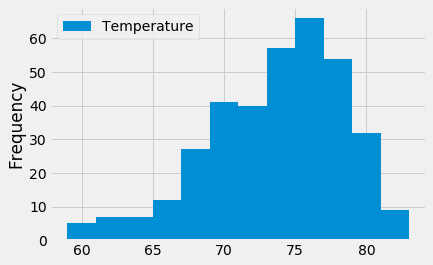

In [26]:
from matplotlib import style
style.use('fivethirtyeight')
last_entry_act_st_q = session.query(Measurement).filter(
    Measurement.station == act_st_id.station).order_by(Measurement.date.desc())
last_entry = last_entry_act_st_q.first().date
prev_year = (dt.datetime.strptime(last_entry, "%Y-%m-%d") - td(365)).strftime("%Y-%m-%d")
temperature_data = session.query(Measurement.tobs).filter(and_(
    Measurement.date >= prev_year,
    Measurement.station == act_st_id.station))

print(temperature_data)
t_df = pd.DataFrame({'Temperature': [val.tobs for val in temperature_data]})
n_bins = 12

# We can set the number of bins with the `bins` kwarg
t_df.plot.hist(bins=n_bins)
plt.savefig('figs/temperature_results.png', bbox_inches='tight')
plt.show()


In [27]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [29]:
prev_y_st = (dt.datetime.strptime('2018-01-01', "%Y-%m-%d") - td(365)).strftime("%Y-%m-%d")
prev_y_end = (dt.datetime.strptime('2018-01-07', "%Y-%m-%d") - td(365)).strftime("%Y-%m-%d")
tmin, tavg, tmax = calc_temps(prev_y_st, prev_y_end)[0]
print(f"During trip from {prev_y_st} to {prev_y_end}")
print(f"Min temperature was {tmin:3.2f}° Avg temperature was {tavg:3.5f}° Max temperature was {tmax:3.2f}°")

During trip from 2017-01-01 to 2017-01-07
Min temperature was 62.00° Avg temperature was 68.36585° Max temperature was 74.00°


In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


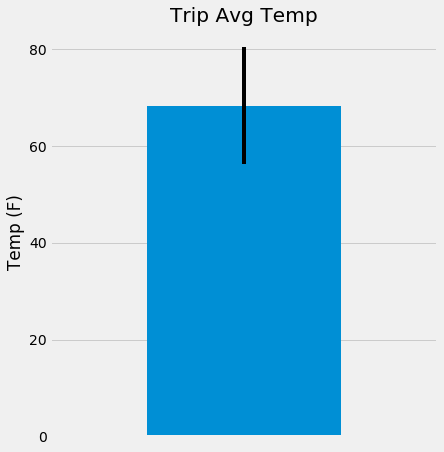

In [31]:
from matplotlib import style
style.use('fivethirtyeight')

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.bar([1], tavg, width=0.4, yerr = tmax-tmin)
ax.set_xlim(0.6, 1.4)
ax.set_yticks([0, 20,40, 60, 80, 100])
ax.set_aspect(0.01)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp')
ax.plot()
plt.savefig('figs/avg_temp.png', bbox_inches='tight')
plt.show()


In [32]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [33]:
#prev_y_st = (dt.datetime.strptime('2013-01-01', "%Y-%m-%d") - td(365)).strftime("%Y-%m-%d")
#prev_y_end = (dt.datetime.strptime('2013-01-07', "%Y-%m-%d") - td(365)).strftime("%Y-%m-%d")
vacation_q = session.query(func.sum(Measurement.prcp).label('PSum'),
              Station.station,
              Station.name,
              Station.latitude,
              Station.longitude,
              Station.elevation).\
              join(Station, Station.station == Measurement.station).\
              filter(Measurement.date >= '2012-01-01').\
              filter(Measurement.date <= '2012-01-07').\
              filter(Measurement.prcp != None).\
              group_by(Station.station).\
              order_by(sqlalchemy.desc('PSum'))

print('The Query is:')
print(vacation_q, '\n')
print(f"{'Station':13}{'Station Name':42}{'Precp':7}{'Latitude':10}{'Longitude':10}{'Elevation':10}")
print("".ljust(91,'='))
for prcp, st, st_name, st_lat, st_lng, st_elev in vacation_q:
    print(f"{st:13}{st_name:42}{prcp:>5.4f}{st_lat:>10.4f}{st_lng:>10.4f}{st_elev:>10.1f}")
print("".ljust(91,'='))

The Query is:
SELECT sum(measurement.prcp) AS "PSum", station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation 
FROM measurement JOIN station ON station.station = measurement.station 
WHERE measurement.date >= ? AND measurement.date <= ? AND measurement.prcp IS NOT NULL GROUP BY station.station ORDER BY "PSum" DESC 

Station      Station Name                              Precp  Latitude  Longitude Elevation 
USC00516128  MANOA LYON ARBO 785.2, HI US              0.3100   21.3331 -157.8025     152.4
USC00519281  WAIHEE 837.5, HI US                       0.2500   21.4517 -157.8489      32.9
USC00518838  UPPER WAHIAWA 874.3, HI US                0.1000   21.4992 -158.0111     306.6
USC00513117  KANEOHE 838.1, HI US                      0.0600   21.4234 -157.8015      14.6
USC00511918  HONOLULU OBSERVATORY 702.2, HI US         0.0000   21.3152 -157.9992       0.9
US

## Optional Challenge Assignment

In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [36]:
st_date = dt.datetime.strptime('2018-01-01', "%Y-%m-%d")
end_date = dt.datetime.strptime('2018-01-07', "%Y-%m-%d")
curr_date = st_date
normals =[]
date_list = []
while curr_date <= end_date:
    date_list.append(curr_date)
    short_cur_date = curr_date.strftime("%m-%d")
    print(short_cur_date)
    curr_date = curr_date + td(1)
    normals.append(*daily_normals(short_cur_date))
normals

01-01
01-02
01-03
01-04
01-05
01-06
01-07


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [38]:
df = pd.DataFrame(normals, columns = ['tmin', 'tavg', 'tmax'])
df['Date'] = pd.to_datetime(date_list)
# #df.index = pd.to_datetime(df.index)
df.set_index('Date', inplace=True)

# # Sort the dataframe by date
# #df.sort_index(inplace=True)

df.head()

,tmin,tavg,tmax
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


In [39]:
# Plot the daily normals as an area plot with `stacked=False`


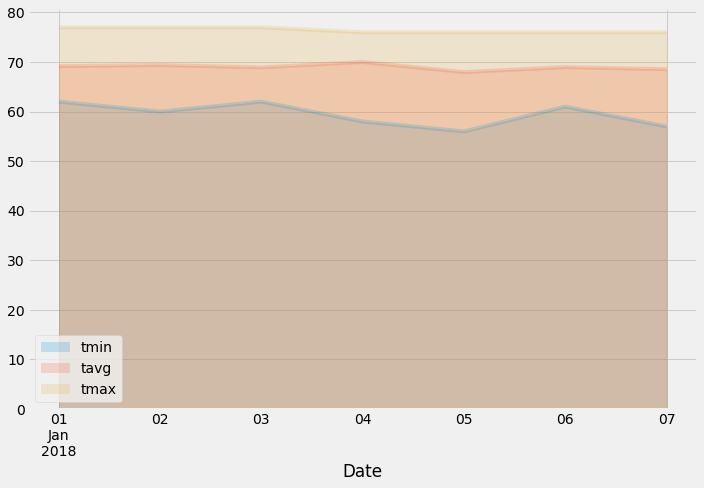

In [40]:
df.plot.area(stacked=False, alpha=0.2, figsize=(10,7))
#plt.margins(x=0)
plt.tight_layout()
plt.savefig('figs/daily_normals.png', bbox_inches='tight')
plt.show()